# Assignment Write-Up

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [31]:
train_dir = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images"
test_dir = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/test_images/test_images"


## Preprocessing
- **Image Rescaling**: All images are rescaled by dividing the pixel values by 255.0. This normalization helps in speeding up the training process and stabilizing the learning.
- **Data Augmentation**: 
  - Random transformations like rotation, width/height shifts, shear, zoom, and horizontal flips were applied to increase the diversity of the training data.
  - This is crucial for preventing overfitting and enhancing the model's ability to generalize to unseen data.
- **Validation Split**: The dataset is split into training and validation sets (80/20) to monitor the model's performance on unseen data during training.


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2) 

# Setting up ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Randomly rotate images by 0 to 20 degrees
    width_shift_range=0.2,    # Shift the image width by a factor of 0.2
    height_shift_range=0.2,   # Shift the image height by a factor of 0.2
    shear_range=0.2,          # Shear the image by 20%
    zoom_range=0.2,           # Zoom in/out on images by 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest',      # Fill in any new pixels created due to rotation or shifts
    validation_split=0.2      # Use 20% of data for validation
)


In [33]:

training_dataset = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256,256),
    batch_size=16,            
    class_mode='binary', 
    subset='training'         
)

validation_dataset = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256,256),
    batch_size=16,             
    class_mode='binary',  
    subset='validation'        
)


Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [34]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(256,256),  
    batch_size=16,           
    class_mode=None,         
    shuffle=False,           
    classes=['.']            
)


Found 400 images belonging to 1 classes.


## Visualizations
- **Image Display**: Random samples of fake, real, and test images were displayed using Matplotlib. This helped in understanding the dataset's diversity and quality.
- **Training and Validation Curves**: Plotted accuracy and loss curves for both training and validation sets. These plots are important for diagnosing model performance and understanding overfitting or underfitting.
- **Confusion Matrix**: A heatmap of the confusion matrix was created using Seaborn. This visualization is effective in understanding model predictions and identifying classes where the model is making errors.


In [35]:
import os
import random
from PIL import Image


Fake_image_directory = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train"
Real_image_directory = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/real_train"
test_image_directory = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/test_images/test_images"

Fake_images = [file for file in os.listdir(Fake_image_directory) if file.endswith(('png', 'jpg', 'jpeg'))]
Real_images = [file for file in os.listdir(Real_image_directory) if file.endswith(('png', 'jpg', 'jpeg'))]
test_images = [file for file in os.listdir(test_image_directory) if file.endswith(('png', 'jpg', 'jpeg'))]

selected_Fake_images = random.sample(Fake_images, 9)
selected_Real_images = random.sample(Real_images, 9)
selected_test_images = random.sample(test_images, 9)


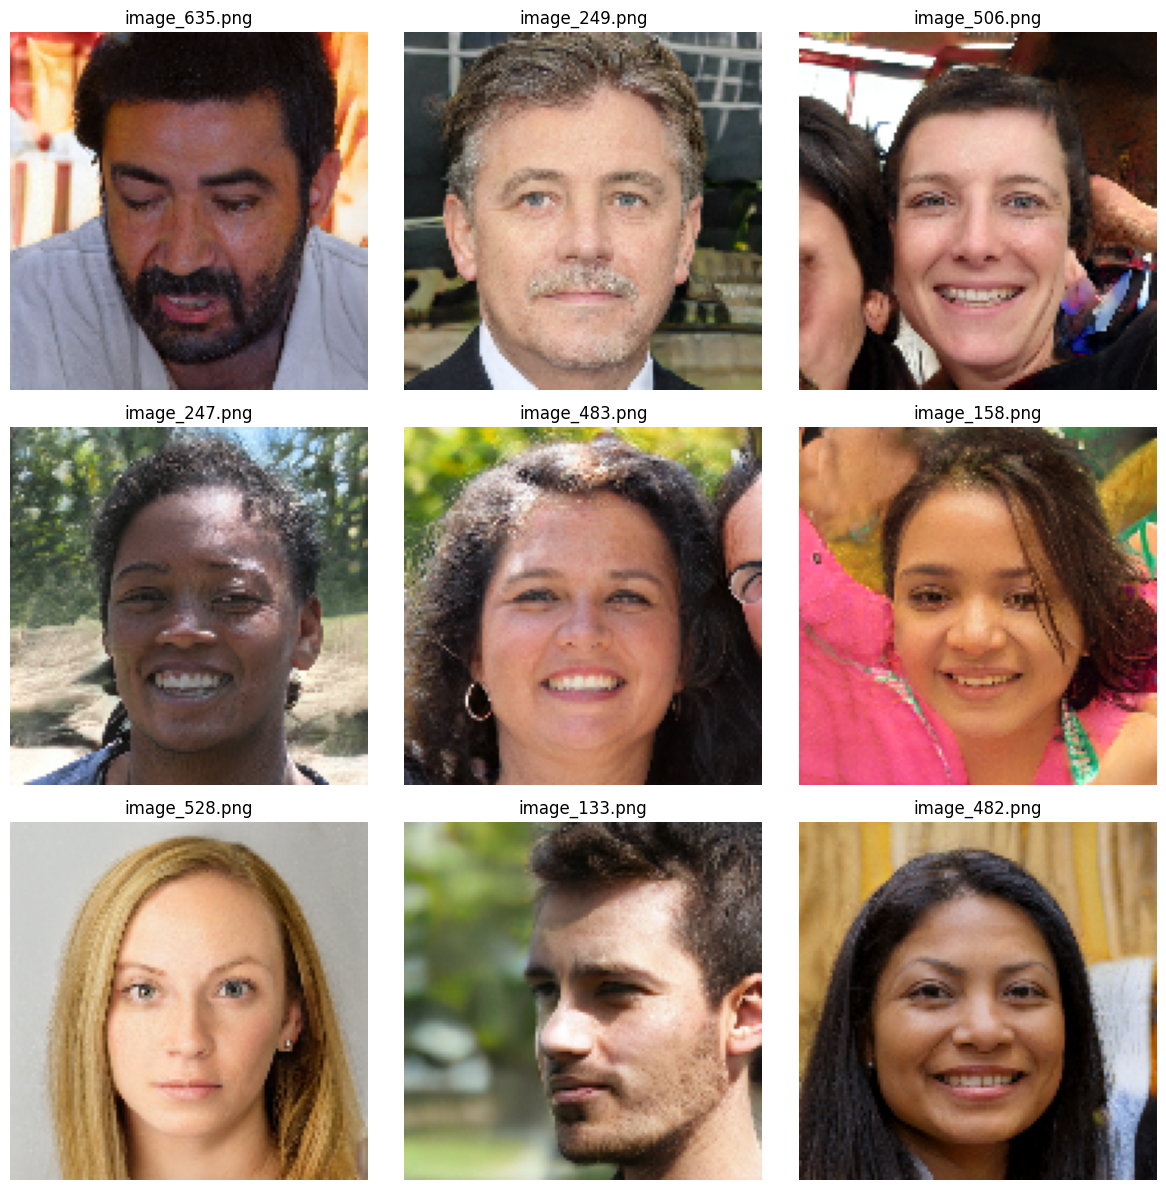

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, img_file in zip(axes.ravel(), selected_Fake_images):
    img_path = os.path.join(Fake_image_directory, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_file)
    ax.axis('off')  # Hide axis
plt.tight_layout()
plt.show()


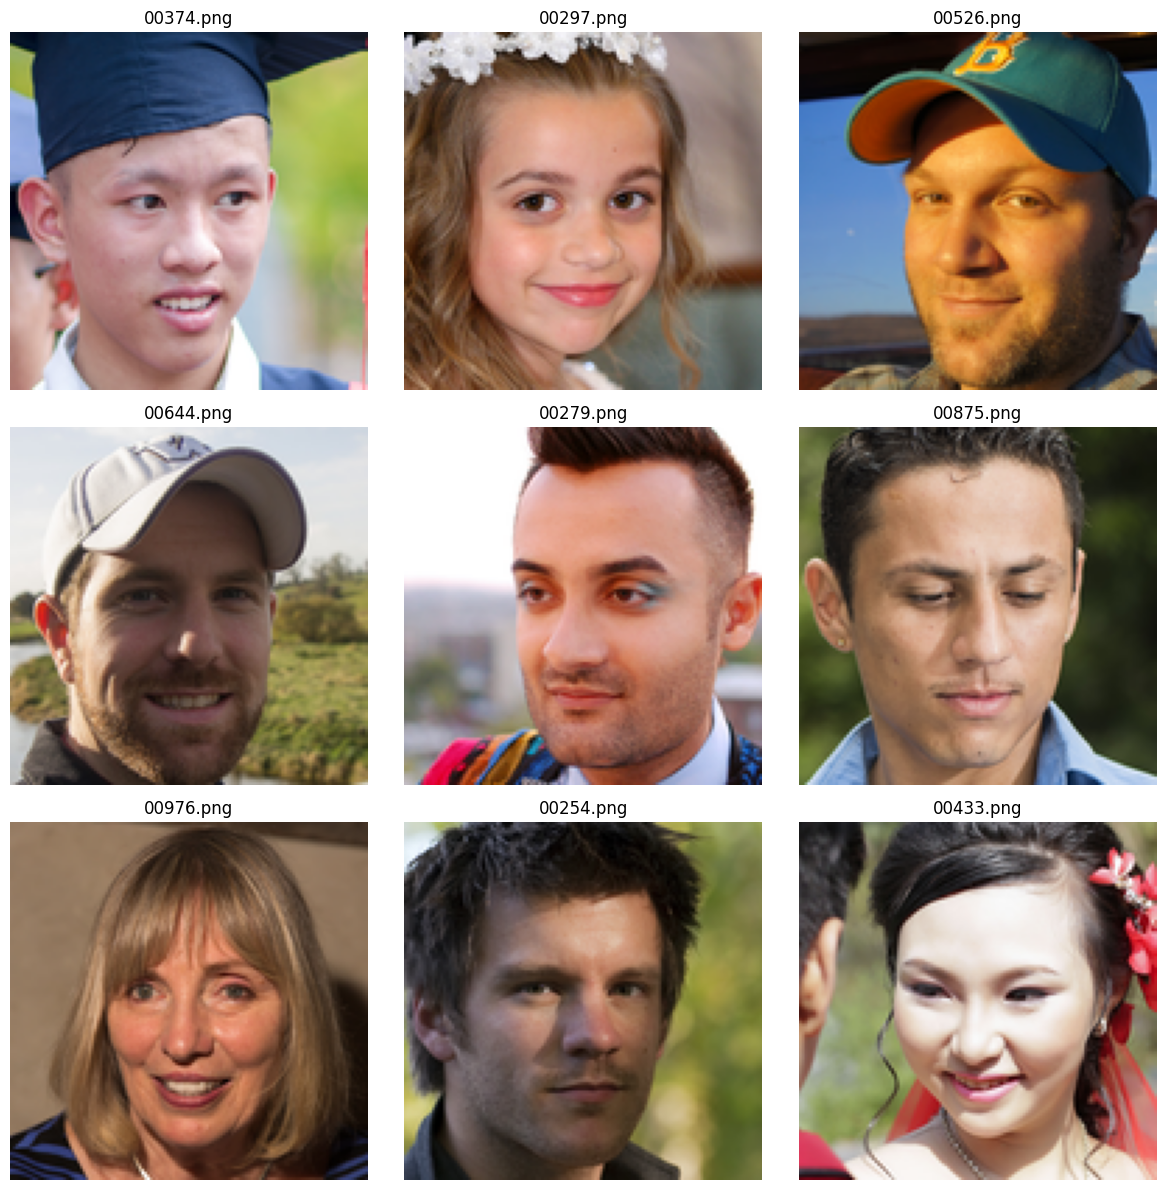

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, img_file in zip(axes.ravel(), selected_Real_images):
    img_path = os.path.join(Real_image_directory, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_file)
    ax.axis('off')  # Hide axis
plt.tight_layout()
plt.show()


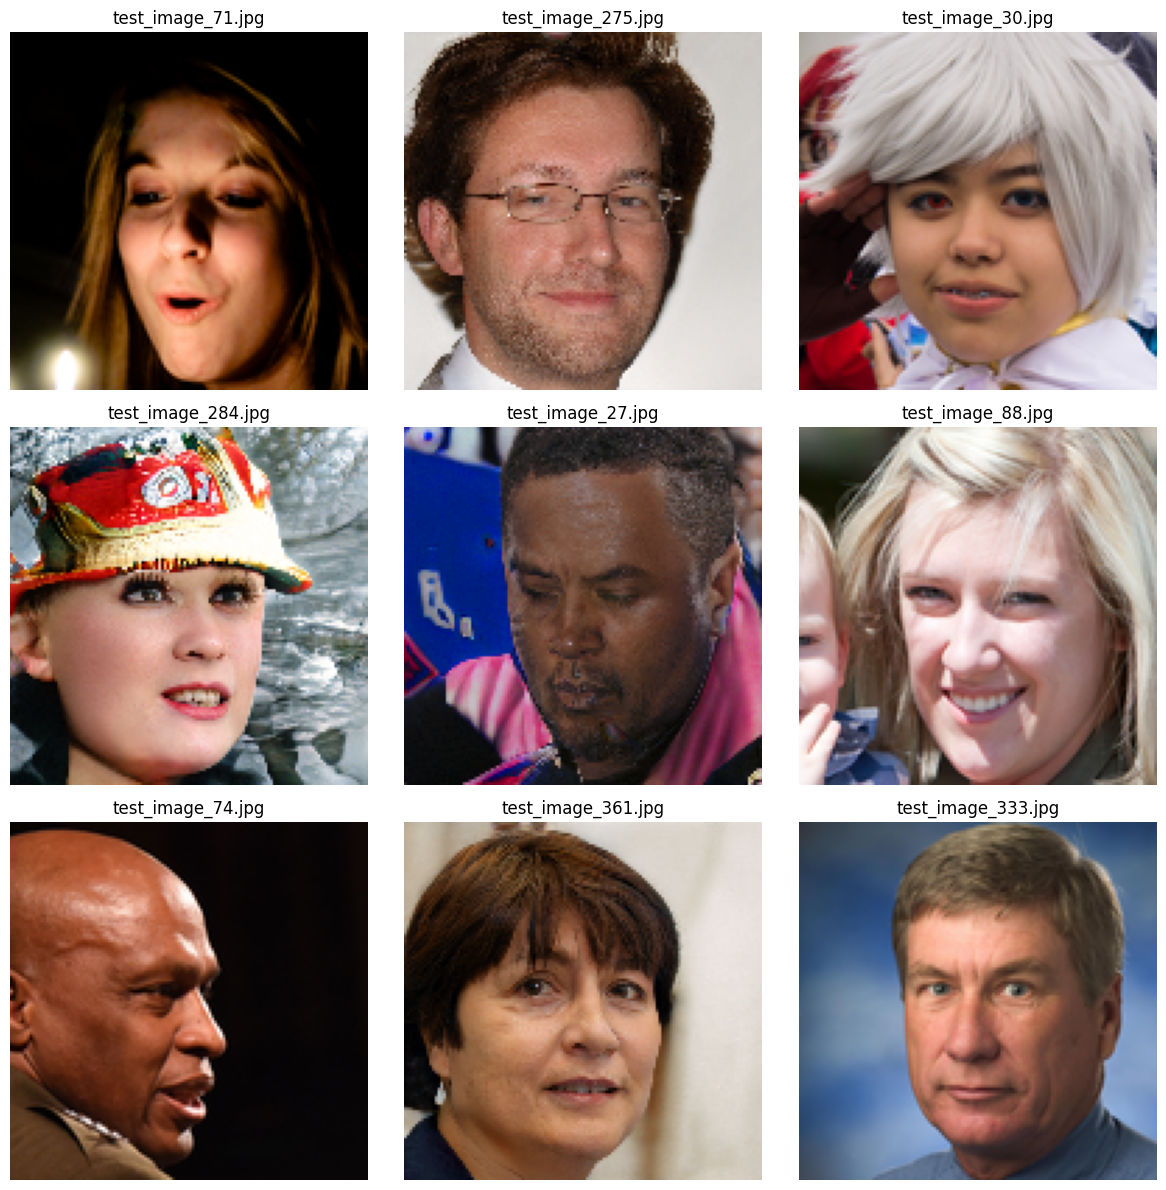

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, img_file in zip(axes.ravel(), selected_test_images):
    img_path = os.path.join(test_image_directory, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_file)
    ax.axis('off')  # Hide axis
plt.tight_layout()
plt.show()


In [39]:
training_dataset.image_shape

(256, 256, 3)

## Modeling
- **Model Architecture**: 
  - A Sequential model was built using convolutional layers (Conv2D) followed by max-pooling layers. This structure captures spatial hierarchies in images.
  - The model ends with a dense layer with a sigmoid activation function, suitable for binary classification.
- **Training Configuration**: 
  - Compiled with binary crossentropy loss, Adam optimizer, and accuracy as a metric.
  - Implemented early stopping and learning rate reduction callbacks to optimize training duration and performance.

In [40]:
def build_model(input_shape=(256, 256, 3)):
    model = models.Sequential()
    
    # Convolutional Base
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,kernel_initializer= 'he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer= 'he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer= 'he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))


    # Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
     
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    
    return model


In [41]:
model = build_model()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,584,961 (112.86 MB)

 Trainable params: 29,584,961 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)


## Evaluation
- **Metrics Used**: 
  - Accuracy is the primary metric for evaluating model performance.
  - The confusion matrix and classification report provided deeper insights into precision, recall, and F1 score for each class.
- **Cross-Validation**: 
  - While the validation split was used, cross-validation techniques were not implemented due to the focus on binary classification and limited dataset size.


In [56]:
from sklearn.metrics import confusion_matrix, classification_report

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Step 5: Train the Model
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9562 - loss: 0.1618 - val_accuracy: 0.8438 - val_loss: 0.5444 - learning_rate: 2.5000e-04
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9733 - loss: 0.0723 - val_accuracy: 0.8094 - val_loss: 0.6205 - learning_rate: 2.5000e-04
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9919 - loss: 0.0282 - val_accuracy: 0.8375 - val_loss: 0.6966 - learning_rate: 2.5000e-04
Epoch 4/25
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9962 - loss: 0.0184
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9962 - loss: 0.0183 - val_accuracy: 0.7906 - val_loss: 0.8520 - learning_rate: 2.5000e-04
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.8375 - val_loss: 0.6866 - learning_rate: 1.2500e-04
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 1.0000 - los

In [46]:
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7747 - loss: 0.5348
Validation Accuracy: 0.76


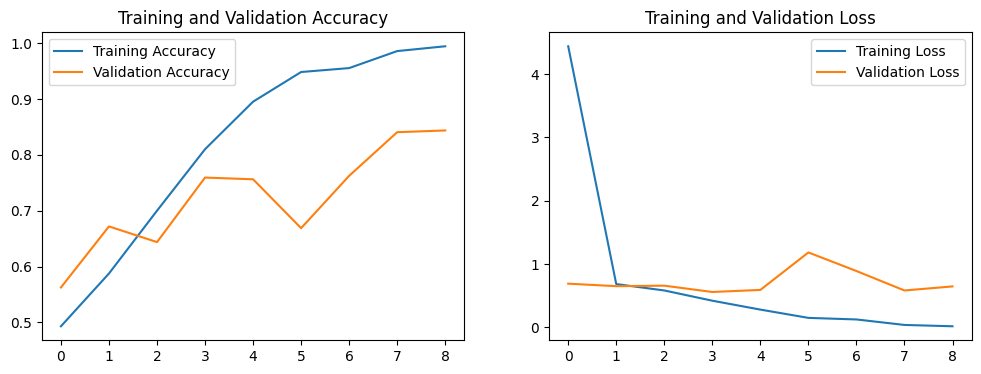

In [47]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


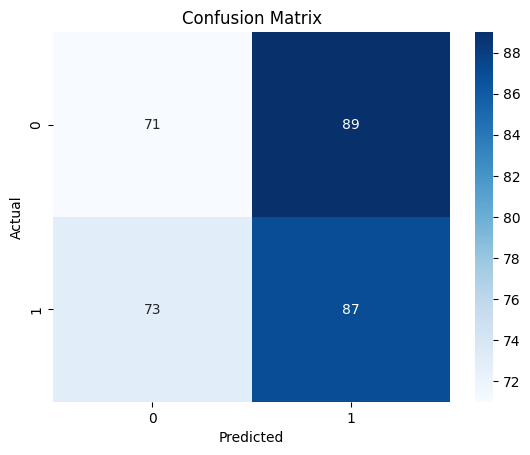

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.44      0.47       160
           1       0.49      0.54      0.52       160

    accuracy                           0.49       320
   macro avg       0.49      0.49      0.49       320
weighted avg       0.49      0.49      0.49       320



In [57]:
import seaborn as sns

Y_pred = model.predict(validation_dataset)
y_pred = np.where(Y_pred > 0.5, 1, 0)

conf_mat = confusion_matrix(validation_dataset.classes, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(validation_dataset.classes, y_pred, target_names=['0', '1']))


In [49]:
import pandas as pd 

file1 = pd.DataFrame({
    'ID': [int(f.split('_')[2].split('.')[0]) for f in os.listdir(test_dir) if f.endswith('.jpg')]})


In [50]:
predictions = model.predict(test_generator)


predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

submission = pd.DataFrame({'ID': file1['ID'], 'TARGET': predicted_labels})
submission.to_csv('submission2.csv', index=False)

print("Submission file created successfully!")


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Submission file created successfully!


# Conclusion

In this assignment, we successfully implemented a convolutional neural network (CNN) for binary image classification to differentiate between fake and real images. The following key points summarize our approach and findings:

- **Data Preprocessing**: We employed rescaling and data augmentation techniques to improve model robustness and prevent overfitting. The validation split allowed for effective monitoring of the model's performance on unseen data.

- **Model Architecture**: A Sequential model with multiple convolutional and max-pooling layers was constructed, culminating in a dense layer suited for binary classification. This architecture effectively captures spatial hierarchies in images.

- **Training and Optimization**: The model was trained using a well-defined loss function and optimizer, with early stopping and learning rate reduction callbacks to ensure efficient training.

- **Evaluation**: We assessed the model's performance using accuracy, confusion matrix, and classification reports, providing valuable insights into the model's strengths and weaknesses.

- **Visualizations**: Through various visualizations, including image samples, training curves, and a confusion matrix heatmap, we gained a clearer understanding of the data and model performance.

Overall, the assignment demonstrates the effective use of CNNs for image classification tasks. Future improvements could include the exploration of transfer learning, additional data preprocessing methods, and hyperparameter tuning to further enhance the model's accuracy and generalization capabilities.